# Bayesian Hierarchical Stacking: Well Switching Case Study

## Intro

Suppose you have just fit 6 models to a dataset, and need to choose which one to use to make predictions on your test set. How do you choose which one to use? A couple of common tactics are:
- choose the best model based on cross-validation;
- average the models, using weights based on cross-validation scores.

In the paper "Bayesian hierarchical stacking: Some models are (somewhere) useful" {cite:t}`yaopirsvehtarigelman2021bhs`, a new technique is introduced: average models based on weights which are allowed to vary across according to the input data, based on a hierarchical structure.

Here, we'll implement the first case study from that paper - readers are nonetheless encouraged to look at the original paper to find other cases studies, as well as theoretical results. Code from the article (in R / Stan) can be found [here](https://github.com/yao-yl/hierarchical-stacking-code).

:::{post} Sep 18, 2021
:tags: case study, hierarchical model, pymc3.Bernoulli, pymc3.Deterministic, pymc3.HalfNormal, pymc3.Model, pymc3.Normal, pymc3.Potential, regression
:category: intermediate
:::

In [1]:
import os

import aesara
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import seaborn as sns

from aesara.tensor.nnet.basic import softmax
from scipy.interpolate import BSpline

You are running the v4 development version of PyMC3 which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc3/tree/v3


In [2]:
%matplotlib inline

In [3]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## 1. Load data, split into train and test sets

The data we have to work with looks at households in Bangladesh, some of which were affected by high levels of arsenic in their water. Would affected households want to switch to a neighbour's well?

We'll split the data into a train and test set, and then we'll train six different models to try to predict whether households would switch wells. Then, we'll see how we can stack them when predicting on the test set!

But first, let's load it in and visualise it!

In [4]:
try:
    wells = pd.read_csv(os.path.join("..", "data", "wells.csv"))
except:
    wells = pd.read_csv(pm.get_data("wells.csv"))

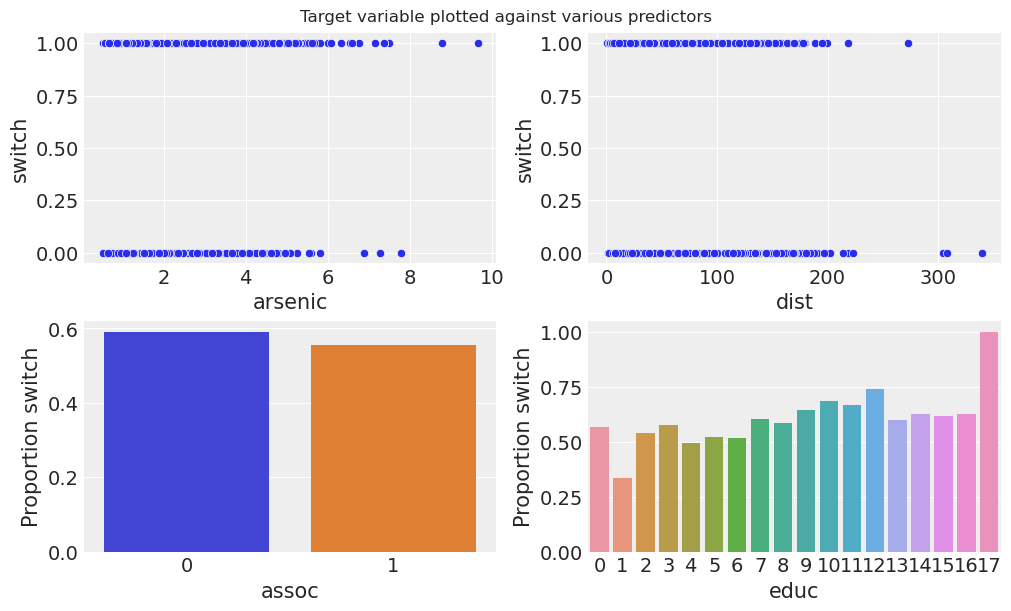

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
fig.suptitle("Target variable plotted against various predictors")
sns.scatterplot(data=wells, x="arsenic", y="switch", ax=ax[0][0])
sns.scatterplot(data=wells, x="dist", y="switch", ax=ax[0][1])
sns.barplot(
    data=wells.groupby("assoc")["switch"].mean().reset_index(), x="assoc", y="switch", ax=ax[1][0]
)
ax[1][0].set_ylabel("Proportion switch")
sns.barplot(
    data=wells.groupby("educ")["switch"].mean().reset_index(), x="educ", y="switch", ax=ax[1][1]
)
ax[1][1].set_ylabel("Proportion switch");

Next, we'll choose 100 observations to be part of our train set, and 1500 to be part of our test set.

In [6]:
np.random.seed(1)
train_id = wells.sample(n=100).index
test_id = wells.loc[~wells.index.isin(train_id)].sample(n=1500).index
y_train = wells.loc[train_id, "switch"].to_numpy()
y_test = wells.loc[test_id, "switch"].to_numpy()

## 2. Prepare 6 different candidate models

### 2.1 Feature Engineering

We're going to start by fitting 6 different models to our train set:

- logistic regression using intercept, arsenic, assoc, edu1, edu2, and edu3;
- same as above, but with logarsenic instead of arsenic;
- same as the first one, but with square and cubic features as well;
- same as the first one, but with spline features derived from logarsenic as well;
- same as the first one, but with spline features derived from dist100 as well;
- same as the first one, but a continuous measure of education.

In [7]:
def bs(x, knots, degree):
    """Replicates bs from splines package in R."""
    padded_knots = np.hstack([[x.min()] * (degree + 1), knots, [x.max()] * (degree + 1)])
    return pd.DataFrame(
        BSpline(padded_knots, np.eye(len(padded_knots) - degree - 1), degree)(x)[:, 1:],
        index=x.index,
    )


knots = np.quantile(wells.loc[train_id, "logarsenic"], np.linspace(0.1, 0.9, num=10))
spline_arsenic = bs(wells["logarsenic"], knots=knots, degree=3)
knots = np.quantile(wells.loc[train_id, "dist100"], np.linspace(0.1, 0.9, num=10))
spline_dist = bs(wells["dist100"], knots=knots, degree=3)

In [8]:
wells["intercept"] = 1
features_0 = ["intercept", "dist100", "arsenic", "assoc", "edu1", "edu2", "edu3"]
features_1 = ["intercept", "dist100", "logarsenic", "assoc", "edu1", "edu2", "edu3"]
features_2 = [
    "intercept",
    "dist100",
    "arsenic",
    "asthird",
    "asSquare",
    "assoc",
    "edu1",
    "edu2",
    "edu3",
]
features_3 = ["intercept", "dist100", "assoc", "edu1", "edu2", "edu3"]
features_4 = ["intercept", "logarsenic", "assoc", "edu1", "edu2", "edu3"]
features_5 = ["intercept", "dist100", "logarsenic", "assoc", "educ"]

X0 = wells.loc[train_id, features_0].to_numpy()
X1 = wells.loc[train_id, features_1].to_numpy()
X2 = wells.loc[train_id, features_2].to_numpy()
X3 = pd.concat([wells.loc[:, features_3], spline_arsenic], axis=1).loc[train_id].to_numpy()
X4 = pd.concat([wells.loc[:, features_4], spline_dist], axis=1).loc[train_id].to_numpy()
X5 = wells.loc[train_id, features_5].to_numpy()

X0_test = wells.loc[test_id, features_0].to_numpy()
X1_test = wells.loc[test_id, features_1].to_numpy()
X2_test = wells.loc[test_id, features_2].to_numpy()
X3_test = pd.concat([wells.loc[:, features_3], spline_arsenic], axis=1).loc[test_id].to_numpy()
X4_test = pd.concat([wells.loc[:, features_4], spline_dist], axis=1).loc[test_id].to_numpy()
X5_test = wells.loc[test_id, features_5].to_numpy()

In [9]:
train_x_list = [X0, X1, X2, X3, X4, X5]
test_x_list = [X0_test, X1_test, X2_test, X3_test, X4_test, X5_test]
K = len(train_x_list)

### 2.2 Training

In [10]:
def logistic(X_train, y_train):
    coords = {"features": np.arange(X_train.shape[1])}
    with pm.Model(check_bounds=False, coords=coords) as model:
        beta = pm.Normal(
            "beta",
            mu=0,
            sigma=3,
            dims="features",
        )
        probs = pm.Deterministic("probs", pm.math.invlogit(pm.math.matrix_dot(X_train, beta)))
        pm.Bernoulli("obs", p=probs, observed=y_train)
    return model

In [11]:
fit_list = []
for k in range(K):
    model = logistic(train_x_list[k], y_train)
    with model:
        idata = pm.sample(draws=1000, tune=1000, return_inferencedata=True)
    fit_list.append(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


### 2.3 Estimate leave-one-out cross-validated score for each training point

Rather than refitting each model 100 times, we will estimate the leave-one-out cross-validated score using LOO (obligatory citation).

In [12]:
def find_point_wise_loo_score(fit):
    return az.loo(fit, pointwise=True, scale="log").loo_i.values


lpd_point = np.vstack([find_point_wise_loo_score(fit) for fit in fit_list]).T
exp_lpd_point = np.exp(lpd_point)

## 3. Bayesian Hierarchical Stacking

### 3.1 Prepare stacking datasets

To determine how the stacking weights should vary across training and test sets, we will need to create stacking datasets. For discrete features, this is easy, we just one-hot-encode them. But for continuous features, we need a trick. In Equation (16), the authors recommend the following: if you have a continuous feature `f`, then replace it with the following two features:

- `f_l`: `f` minus the median of `f`, clipped above at 0;
- `f_r`: `f` minus the median of `f`, clipped below at 0;

In [13]:
dist100_median = wells.loc[wells.index[train_id], "dist100"].median()
logarsenic_median = wells.loc[wells.index[train_id], "logarsenic"].median()
wells["dist100_l"] = (wells["dist100"] - dist100_median).clip(upper=0)
wells["dist100_r"] = (wells["dist100"] - dist100_median).clip(lower=0)
wells["logarsenic_l"] = (wells["logarsenic"] - logarsenic_median).clip(upper=0)
wells["logarsenic_r"] = (wells["logarsenic"] - logarsenic_median).clip(lower=0)

stacking_features = [
    "edu0",
    "edu1",
    "edu2",
    "edu3",
    "assoc_half",
    "dist100_l",
    "dist100_r",
    "logarsenic_l",
    "logarsenic_r",
]
X_stacking_train = wells.loc[train_id, stacking_features].to_numpy()
X_stacking_test = wells.loc[test_id, stacking_features].to_numpy()

### 3.2 Define stacking model

What we seek to find is a matrix of weights $W$ with which to multiply the models' predictions. Let's define a matrix $Pred$ such that $Pred_{i, k}$ represents the prediction made for point $i$ by model $k$. Then the final prediction for point $i$ will be:

$$ \sum_k W_{i, k}Pred_{i, k} $$

Such a matrix $W$ would be required to have each column sum to $1$. Hence, we calculate each row $W_i$ of $W$ as:

$$ W_i = \text{softmax}(X\text{_stacking}_i \cdot \beta), $$

where $\beta$ is a matrix whose values we seek to determine. For the discrete features, $\beta$ is given a hierarchical structure over the possible inputs. Continuous features, on the other hand, get no hierarchical structure and just vary according to the input values.

Notice how a non-centered parametrisation is used: see [Why hierarchical models are awesome, tricky, and Bayesian](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) for more on this topic.

In [14]:
def stacking(
    X,
    d_discrete,
    X_test,
    exp_lpd_point,
    tau_mu,
    tau_sigma,
):
    N = X.shape[0]
    d = X.shape[1]
    N_test = X_test.shape[0]
    K = lpd_point.shape[1]
    coords = {
        "continuous_features": np.arange(d - d_discrete),
        "discrete_features": np.arange(d_discrete),
        "features": np.arange(d),
        "models": np.arange(K),
        "models_minus_1": np.arange(K - 1),
    }

    with pm.Model(check_bounds=False, coords=coords) as model:
        beta_con = pm.Normal(
            "beta_con", mu=0, sigma=1, dims=("models_minus_1", "continuous_features")
        )
        tau = pm.Normal(
            "tau",
            mu=0,
            sigma=1,
            dims=("models_minus_1", "discrete_features"),
        )
        mu = pm.Normal(
            "mu",
            mu=0,
            sigma=tau_mu,
            dims="models_minus_1",
        )
        sigma = pm.HalfNormal(
            "sigma",
            sigma=tau_sigma,
            dims="models_minus_1",
        )

        beta = pm.Deterministic(
            "beta",
            pm.math.stack(
                [
                    pm.math.concatenate([mu[k] + sigma[k] * tau[k], beta_con[k]])
                    for k in range(K - 1)
                ],
            ),
        )

        f = pm.Deterministic(
            "f",
            pm.math.concatenate(
                [
                    pm.math.stack(
                        [pm.math.matrix_dot(X, beta[k]) for k in range(K - 1)],
                        axis=1,
                    ),
                    aesara.tensor.zeros((N, 1)),
                ],
                axis=1,
            ),
        )
        w = pm.Deterministic("w", softmax(f))

        logp = pm.math.log((exp_lpd_point * w).sum(axis=1))
        pm.Potential("logp", pm.math.sum(logp))

        f_test = pm.Deterministic(
            "f_test",
            pm.math.concatenate(
                [
                    pm.math.stack(
                        [pm.math.matrix_dot(X_test, beta[k]) for k in range(K - 1)],
                        axis=1,
                    ),
                    aesara.tensor.zeros((N_test, 1)),
                ],
                axis=1,
            ),
        )
        w_test = pm.Deterministic(
            "w_test",
            softmax(f_test),
        )

    return model

In [15]:
model = stacking(
    X=X_stacking_train,
    d_discrete=4,
    X_test=X_stacking_test,
    exp_lpd_point=exp_lpd_point,
    tau_mu=1.0,
    tau_sigma=0.5,
)
with model:
    idata = pm.sample(draws=1000, tune=1000, return_inferencedata=True, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_con, tau, mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


We can now extract the weights with which to weight the different models from the posterior, and then visualise how they vary across the training set.

Let's compare them with what the weights would've been if we'd just used fixed stacking weights derived from the LOO scores. Notice how Bayesian Hierarchical Stacking induces a shrinkage effect!

In [16]:
w = idata.posterior.w.mean(dim=("chain", "draw"))

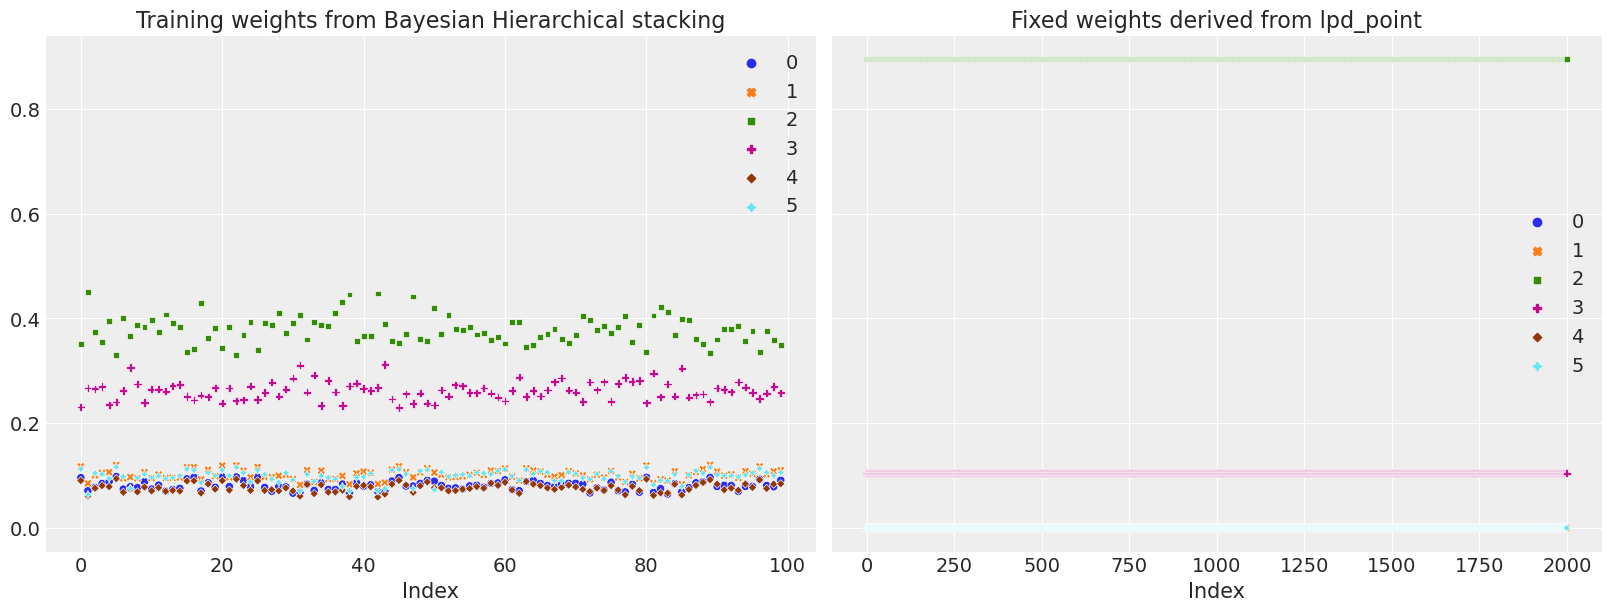

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharey=True)
sns.scatterplot(data=pd.DataFrame(w.values), ax=ax[0])
sns.scatterplot(
    data=pd.DataFrame(
        np.hstack(
            [scipy.special.softmax(lpd_point.sum(axis=0))[:, np.newaxis] for _ in range(2000)]
        ).T
    ),
    ax=ax[1],
)
ax[0].set_title("Training weights from Bayesian Hierarchical stacking")
ax[1].set_title("Fixed weights derived from lpd_point")
ax[0].set_xlabel("Index")
ax[1].set_xlabel("Index");

## 8. Make predictions

Now, for each model, let's evaluate the log predictive density for each point in the test set.

In [18]:
train_preds = []
for k in range(K):
    train_pred = scipy.special.expit(
        np.matmul(
            train_x_list[k], fit_list[k].posterior.beta.stack(samples=("chain", "draw")).values
        )
    )
    train_preds.append(train_pred.mean(axis=1))
train_preds = np.vstack(train_preds).T

In [19]:
preds = []
for k in range(K):
    post_pred = scipy.special.expit(
        np.matmul(
            test_x_list[k], fit_list[k].posterior.beta.stack(samples=("chain", "draw")).values
        )
    )
    preds.append(post_pred.mean(axis=1))
preds = np.vstack(preds).T

Once we have predictions for each model, we need to think about how to combine them, such that for each test point, we get a single prediction.

We decided we'd do this in three ways:
- Bayesian Hierarchical Stacking (`bhs_pred`);
- choosing the model with the best LOO score (`model_selection_preds`);
- fixed-weights stacking based on LOO scores (`fixed_weights_preds`).

In [20]:
w_test = idata.posterior.w_test.mean(dim=("chain", "draw"))
bhs_predictions = (w_test * preds).sum(axis=1)
model_selection_preds = preds[:, lpd_point.sum(axis=0).argmax()]
fixed_weights_preds = (scipy.special.softmax(lpd_point.sum(axis=0)) * preds).sum(axis=1)

## 9. Predict on test set

Let's compare the log predictive density scores on the test set (note: higher is better):

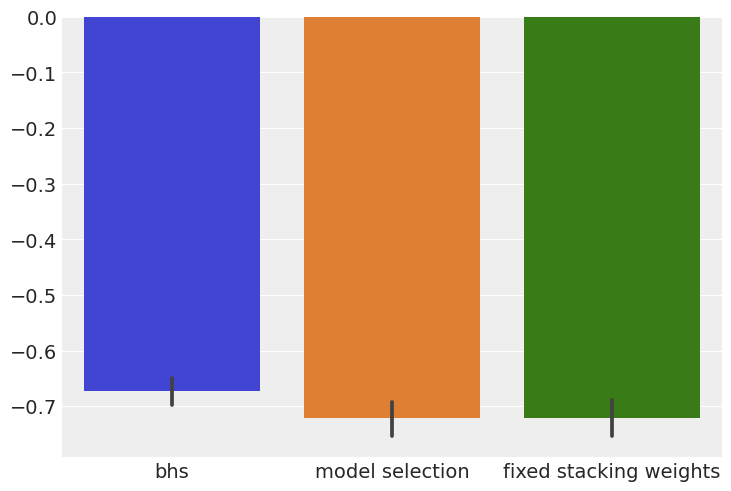

In [22]:
logpms = pd.DataFrame(
    np.vstack(
        [
            stats.bernoulli(p=bhs_predictions).logpmf(y_test),
            stats.bernoulli(p=model_selection_preds).logpmf(y_test),
            stats.bernoulli(p=fixed_weights_preds).logpmf(y_test),
        ]
    ).T,
    columns=["bhs", "model selection", "fixed stacking weights"],
)
sns.barplot(data=logpms);

In [23]:
logpms.describe()

,bhs,model selection,fixed stacking weights
count,1500.000000,1500.000000,1500.000000
mean,-0.672801,-0.721295,-0.721284
std,0.481086,0.641909,0.638686
min,-2.396933,-3.336379,-3.135954
25%,-0.925297,-1.060964,-1.067340
50%,-0.531172,-0.491192,-0.489197
75%,-0.307519,-0.232126,-0.234176
max,-0.077258,-0.017688,-0.022037


So, in this dataset, with this particular train-test split, Bayesian Hierarchical Stacking does indeed bring a small gain compared with model selection and compared with fixed-weight stacking.

### Does this prove that Bayesian Hierarchical Stacking works?

No - for more comprehensive results, literature review, and proofs, please see the original paper. The goal of this notebook is just to show how to implement the technique in PyMC3.

## Conclusion

We've seen how Bayesian Hierarchical Stacking can help us average models with input-dependent weights, in a manner which doesn't overfit. We only implemented the first case study from the paper, but readers are encouraged to check out the other two as well. Also check the paper for theoretical results and results from more experiments.

## References

:::{bibliography}
:filter: docname in docnames

yaopirsvehtarigelman2021bhs
:::

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,xarray

Last updated: Sat Sep 18 2021

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.26.0

aesara: 2.1.3
xarray: 0.19.0

aesara    : 2.1.3
arviz     : 0.11.2
numpy     : 1.21.1
pymc3     : 4.0
scipy     : 1.7.1
matplotlib: 3.4.3
seaborn   : 0.11.2
pandas    : 1.3.1

Watermark: 2.2.0

